In [1]:
# extract bg/gain map from unstreaked images
import numpy as np
import h5py
import psana as ps
from tqdm import tqdm_notebook
import scipy
import sys
sys.path.append('/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex')
import gData
sys.path.append('/reg/neh/home/tdd14/modules/quadrant/quadrant')
import quadrant
sys.path.append('/reg/neh/home/tdd14/modules/general')
from functions import bin2d
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
from scipy.ndimage import median_filter as mf
from scipy.ndimage import gaussian_filter as gf
from matplotlib import colors
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
#%matplotlib nbagg
import cv2

/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex/gData.py:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if gData['rBF'] is not 'custom':


In [2]:
#define some functions
def shift(im, shifts):
    "shifts either (xshift,yshift) or one number for both. yshift is rows, xshift is cols"
    import cv2
    if type(shifts)!=tuple: xshift=yshift=shifts
    else: xshift,yshift=shifts[0],shifts[1]
    rows,cols = im.shape
    M=np.float32([[1,0,xshift],[0,1,yshift]])
    return cv2.warpAffine(im,M,(cols,rows))

def get_basis(K, TH=np.array([0]), R=0, sig=1, nx=64, sub=0, q=0, force=False):
    "this from Elio"
    from gData import loadG, get_gData
    from quadrant import unfoldQuadrant
    import warnings
    savepath = 'G_r%d_k%d_l2_sig%.f.h5' % (nx//2+1, len(K), sig)
    try:
        if force:
            raise ValueError
        gData = loadG(savepath)
    except:
        lmax=2
        gData = {}
        gData['rBF'] = 'gauss'
        gData['x'] = np.arange(nx//2+1, dtype='double')
        gData['k'] = K
        gData['params'] = sig
        gData['l'] = 2 * np.arange(lmax/2 + 1).astype(int)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            get_gData(gData, silent=True, save_path=savepath)
        gData = loadG(savepath)
    nk = len(K)
    nth = len(TH)
    G = gData['Up'].T.dot(np.diag(gData['S']).dot(gData['V'].T))
    G = 2*G[:,nk:] + G[:,:nk]
    basis = np.zeros((nx**2, nk*nth))
    for ik, k in enumerate(K):
        im = shift(unfoldQuadrant(G[:, ik].reshape(nx//2+1, nx//2+1)), (0.5))[1:, 1:] #0.5
        for ith, th in enumerate(TH*np.pi/180):
            imshift = shift(im, (-R*np.sin(th), R*np.cos(th)))
            basis[:, ik + nk*ith] = (imshift - sub*im).flatten() * k**q
    return basis, gData['frk']

def gauss(x, sigma, mu):
    return (1./(sigma*(np.sqrt(2*np.pi)))) * \
           np.exp(-np.power((x-mu)/float(sigma), 2)/2.)

def centreg(x, maxbtw=(30,100), frac=0.0):
    'takes only the main lobe of the constants for the fitted Gaussians'
    maxind=np.argmax(x[int(maxbtw[0]):int(maxbtw[1]+1)])+maxbtw[0]
    half=frac*x[int(maxind)] #will hopefully be zero
    try:
        x_down=int(np.nanmax(np.where(x[:int(maxind)]<=half)[0]))
        x_up=int(np.nanmin(np.where(x[int(maxind+1):]<=half)[0])+maxind+1)     
    except: #if it doesn't drop to specified value on one of the sides
        x_down=0; x_up=len(x)-1
        print( 'zeroes not found')
    mask=np.zeros(x.shape, dtype=bool)
    mask[x_down:x_up+1]=True
    x2ret=np.copy(x)
    x2ret[~mask]=0
    return x2ret, x_up-x_down

def rebin(arr, n=2):
    sy, sx = arr.shape
    shape = (int(sy/n), int(n), int(sx/n), int(n))
    return np.nanmean(np.nanmean(arr.reshape(shape), axis=-1), axis=1)

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
my_cmap = cm.get_cmap('jet')
xr = np.linspace(0, 1, 2000)
my_cmap = my_cmap(xr)
my_cmap[0:2,-1] = 0
my_cmap = ListedColormap(my_cmap)


#mask to block bright spots by the hole
x,y, = 530,512
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-x)**2+(Y-y)**2)
mask=np.zeros((1024,1024))
mask[rs>1*48]=1

## Gather unstreaked images to make bg with

In [89]:
#tmoc00118, run 286, 289
#runnum = 286 #121 #110 #112
runnum = 112 #127
nn = 100
gmin = 0.11
gas_jet = 1
bins = np.linspace(32e6,62e6,14)
bins[-1] = 120e6
bins[-2] = 80e6
bins[-3] = 70e6
bins[0] = 19e6

bgdat = np.ndarray(len(bins), dtype = [('bins', float), ('quads', float, 4), ('bg_im', float, (64,64)),\
                                           ])
bgdat['bins'] = bins


ds=ps.DataSource(exp = 'tmox51020', run= runnum)
#ds=ps.DataSource(exp = 'tmoc00118', run= runnum)
run = next(ds.runs())
bg_ims = []
detsum = []
streak_ims = []
timestamps = []

n = 0


gmd = run.Detector("gmd") # gas intensity detector 
timing = run.Detector('timing') # this gives access to evr codes
#atmopal = run.Detector('tmo_atmopal')
#ebeam = run.Detector("ebeam")
opal1 = run.Detector('tmo_opal1') 

for nevent, event in enumerate(run.events()): # loop over events (shots) in the run
    
    opal1im_i=np.copy(opal1.raw.raw(event))
    gd_i=gmd.raw.energy(event)
    evr=timing.raw.eventcodes(event)

    # identify relevant event codes
    gas=evr[70] # did the gas jet fire
    ir_timed=evr[67] # was the ir laser timed
    ir_misttimed=evr[68] # was the ir laser mis-timed
    

    if opal1im_i is None or gd_i is None or gd_i<gmin or (gas != gas_jet): continue
    
    #background
    if (ir_timed != 1):
        im_look = np.rot90(opal1im_i*mask)

        #if np.sum(im_look) < 36e6: continue #optional, cut out images without signal
        # if np.sum(im_look) < 42e6: continue 
        # if np.sum(im_look) > 60e6: continue
        # if np.sum(im_look) < 40e6: continue 
        # if np.sum(im_look) > 50e6: continue
        if np.sum(im_look) < 32e6: continue
        detsum.append(np.sum(im_look))
        bg_ims.append(im_look)
        timestamps.append(event.timestamp)
        n +=1
    # if (ir_timed == 1):
    #     im_look = np.rot90(opal1im_i*mask)
    #     if np.sum(im_look) < 36e6: continue #optional, cut out images without signal
    #     streak_ims.append(im_look)
    # if (len(bg_ims) > nn)&(len(streak_ims) > nn):
    #     break
    if (len(bg_ims) > nn):
        break
    if n%10 == 0: 
        print(n) 
        a = np.histogram(detsum, bins = bins)
        print(['%1.0f-%1.0f: %1.0f, ' %(a[1][i]/1e6,a[1][i+1]/1e6,a[0][i]) for i in range(len(a[0]))])

bg_ims = np.array(bg_ims)
bg_ims.shape

0
['19-34: 0, ', '34-37: 0, ', '37-39: 0, ', '39-41: 0, ', '41-44: 0, ', '44-46: 0, ', '46-48: 0, ', '48-50: 0, ', '50-53: 0, ', '53-55: 0, ', '55-70: 0, ', '70-80: 0, ', '80-120: 0, ']
10
['19-34: 3, ', '34-37: 1, ', '37-39: 1, ', '39-41: 1, ', '41-44: 0, ', '44-46: 1, ', '46-48: 1, ', '48-50: 1, ', '50-53: 0, ', '53-55: 0, ', '55-70: 1, ', '70-80: 0, ', '80-120: 0, ']
10
['19-34: 3, ', '34-37: 1, ', '37-39: 1, ', '39-41: 1, ', '41-44: 0, ', '44-46: 1, ', '46-48: 1, ', '48-50: 1, ', '50-53: 0, ', '53-55: 0, ', '55-70: 1, ', '70-80: 0, ', '80-120: 0, ']
10
['19-34: 3, ', '34-37: 1, ', '37-39: 1, ', '39-41: 1, ', '41-44: 0, ', '44-46: 1, ', '46-48: 1, ', '48-50: 1, ', '50-53: 0, ', '53-55: 0, ', '55-70: 1, ', '70-80: 0, ', '80-120: 0, ']
10
['19-34: 3, ', '34-37: 1, ', '37-39: 1, ', '39-41: 1, ', '41-44: 0, ', '44-46: 1, ', '46-48: 1, ', '48-50: 1, ', '50-53: 0, ', '53-55: 0, ', '55-70: 1, ', '70-80: 0, ', '80-120: 0, ']
10
['19-34: 3, ', '34-37: 1, ', '37-39: 1, ', '39-41: 1, ', '41-44

(101, 1024, 1024)

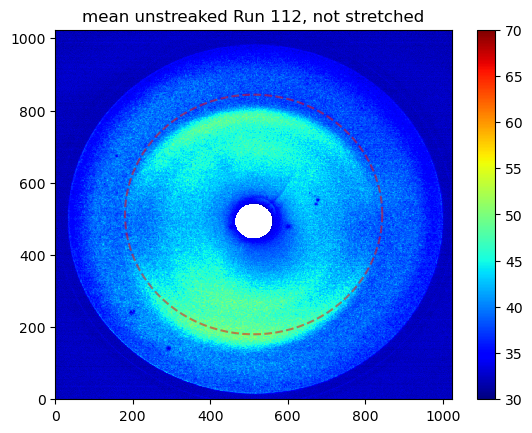

In [78]:
phi_rad = np.linspace(0,360,100)*np.pi/180
plt.pcolormesh(np.mean(bg_ims,axis = 0), cmap = my_cmap, vmin = 30, vmax = 70)#, vmin = 4, vmax = 5)
plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.colorbar()
plt.title('mean unstreaked Run %1.0f, not stretched' %runnum)
plt.show()

# a = np.mean(streak_ims,axis = 0)
# bb= np.mean(bg_ims,axis = 0)

# plt.pcolormesh(np.rot90(bb,-1), cmap = my_cmap) #, vmin = 30, vmax = 50)#, vmin = 4, vmax = 5)
# plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
# plt.colorbar()
# plt.title('mean unstreaked Run %1.0f, not stretched' %runnum)
# plt.show()

# phi_rad = np.linspace(0,360,100)*np.pi/180

# plt.pcolormesh(np.rot90(a/np.sum(a),-1)-np.rot90(bb/np.sum(bb),-1), cmap = 'bwr')#, vmin = 4, vmax = 5)
# plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
# plt.colorbar()
# plt.title('mean streak - unstreaked Run %1.0f, not stretched' %runnum)
# plt.show()

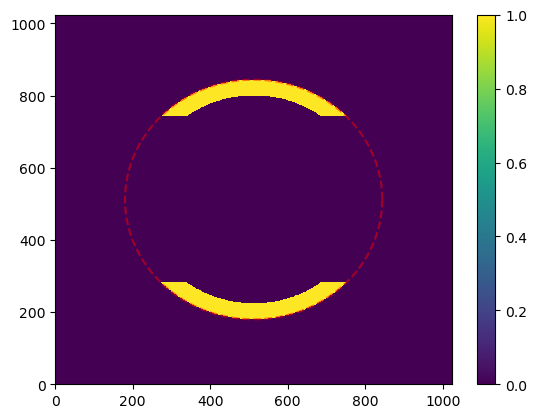

In [79]:
##part of the image to use to try and balance gain and stuff
#centered
## used in the stretch fit and quads fit
if runnum == 127:
    X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
    rs=np.sqrt((X-512)**2+(Y-512)**2)
    maskhole=np.zeros((1024,1024))
    maskhole[(rs>288) & (rs<332)]=1
    maskhole[(Y>512-230) & (Y<512+230)]=0
    
if runnum == 112:
    X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
    rs=np.sqrt((X-512)**2+(Y-512)**2)
    maskhole=np.zeros((1024,1024))
    maskhole[(rs>288) & (rs<332)]=1
    maskhole[(Y>512-230) & (Y<512+230)]=0
    
plt.pcolormesh(maskhole)
plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.colorbar()

In [80]:
from scipy.optimize import minimize

def make_MM(x0):
    xshift, yshift =  x0[8], x0[9] 

    # Coordinates that you want to Perspective Transform
    pts1 = np.float32([[0,0],\
                       [0,1024],\
                       [1024,0],\
                       [1024, 1024]])


    # Size of the Transformed Image
    pts2 = np.float32([[0+xshift-x0[0],0 + yshift-x0[1]],\
                       [0+xshift-x0[2],1024 + yshift-x0[3]],\
                       [1024+xshift-x0[4],0 + yshift-x0[5]],\
                       [1024+xshift-x0[6],1024 + yshift-x0[7]]])

    MM = cv2.getPerspectiveTransform(pts1,pts2)
    return MM

def MM_error(x0, im):
    mm = make_MM(x0)
    imm = cv2.warpPerspective(im,mm,(1024,1024))
    diffud = rebin(imm*maskhole-np.flipud(imm)*maskhole,4)*2
    difflr = rebin(imm*maskhole-np.fliplr(imm)*maskhole,4)*2
    #SSE = np.sum(diffud**2)
    #return np.sum(diffud**2)/np.linalg.norm(diffud) + np.sum(difflr**2)/np.linalg.norm(difflr)
    return np.sum(diffud**2)/np.linalg.norm(diffud) + np.sum(difflr**2)/np.linalg.norm(difflr)+(np.max(diffud) + np.max(difflr))**2
    #return np.max(diffud) + np.max(difflr)
    #return SSE/np.linalg.norm(diffud)
    

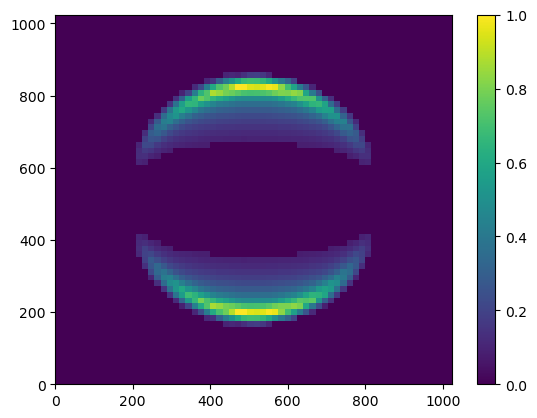

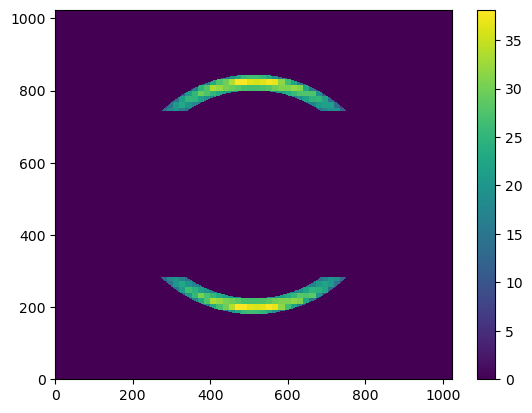

In [81]:
M0 = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Jan/unstreaked_M0_112.npy')
M0 = M0/np.max(M0)
plt.pcolormesh(M0)
plt.colorbar()
plt.show()
M00 = M0*maskhole
M00 = M00/np.sum(M00)*1e6
plt.pcolormesh(M00)
plt.colorbar()
plt.show()

def MM_error2(x0, im):
    mm = make_MM(x0)
    imm = cv2.warpPerspective(im,mm,(1024,1024))*maskhole
    imm = imm/np.sum(imm)*1e6
    diff = (imm - M00)
    diffud = rebin(diff-np.flipud(diff),4)
    difflr = rebin(diff-np.fliplr(diff),4)
    return np.sum(diffud**2)+np.sum(difflr**2)
    #return np.max(diffud) + np.max(difflr)
    #return SSE/np.linalg.norm(diffud)

## Stretch the image

In [82]:
xshift0 = 1
yshift0 = 49
X0 = [-17,  14.9, -4.1, -16, 10,  14.9, 3, 16, xshift0, yshift0]

# res = minimize(MM_error, X0, args = (np.mean(bg_ims,axis = 0)),
#                bounds = [(-15,15), (-15,15),(-15,15),(-15,15),(-15,15),(-15,15),(-15,15),(-15,15),(-50,50),(-50,50)],
#                method = 'Powell') #, options = {'maxiter': 5, 'maxfev': 4})
# print(res.x)

# res = minimize(MM_error2, X0, args = (np.mean(bg_ims,axis = 0)),
#                bounds = [(-18,18), (-18,18),(-18,18),(-18,18),(-18,18),(-18,18),(-18,18),(-18,18),(-55,55),(-55,55)],
#                method = 'Powell') #, options = {'maxiter': 5, 'maxfev': 4})
# print(res.x)

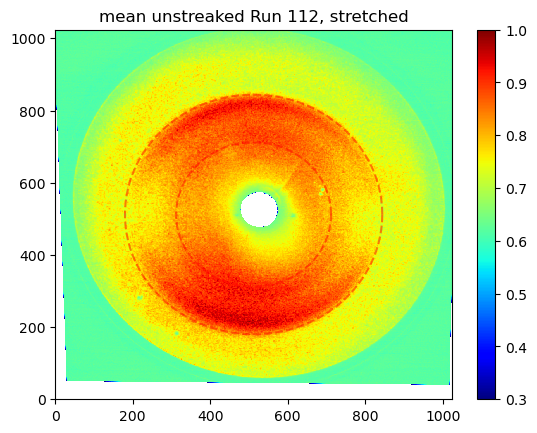

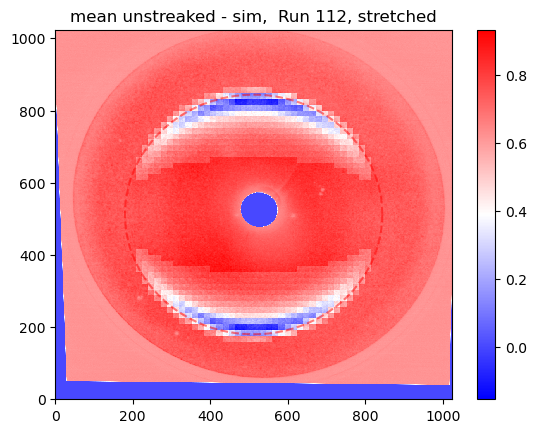

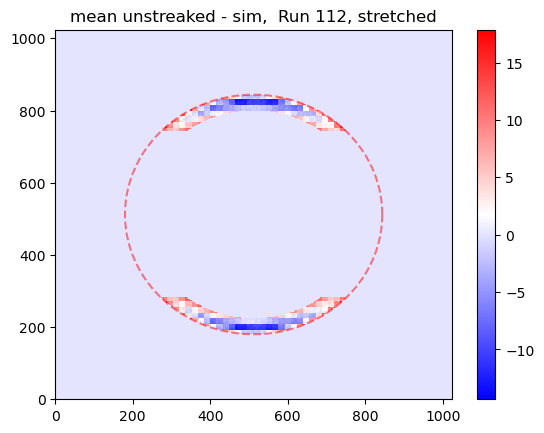

In [93]:
#MM = make_MM(res.x)
MM = make_MM([-17.998,-2.74, 17.9, -17.39, 17.86, 8.52, -3.85, 17.9, 11.47, 47.86])
Mp = cv2.warpPerspective(np.mean(bg_ims,axis = 0),MM,(1024,1024))
Mp = Mp/np.max(Mp)


plt.pcolormesh(Mp, cmap = my_cmap, vmin = 0.3) #, vmin = 40, vmax = 70)
plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.plot((512+200*np.cos(phi_rad)), (512+200*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.colorbar()
plt.title('mean unstreaked Run %1.0f, stretched' %runnum)
plt.show()

plt.pcolormesh(Mp - M0, cmap = 'bwr')
plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.colorbar()
plt.title('mean unstreaked - sim,  Run %1.0f, stretched' %runnum)
plt.show()

Mp = Mp*maskhole
Mp = Mp/np.sum(Mp)*1e6

plt.pcolormesh(Mp - M00, cmap = 'bwr')
plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.colorbar()
plt.title('mean unstreaked - sim,  Run %1.0f, stretched' %runnum)
plt.show()



# #for Siqi X=535 y=512, her dipole is rotated differently 
# MM = make_MM([0,0, 0, 0, 0, 0, 0, 0, 512-535, 512-512])
# #MM = make_MM([0,0, 0, 0, 0, 0, 0, 0, 512-(535+3), 512-(512-6)])
# Mp = cv2.warpPerspective(np.rot90(bb,-1),MM,(1024,1024))
# Ma = cv2.warpPerspective(np.rot90(a,-1),MM,(1024,1024))

# plt.pcolormesh(Mp, cmap = my_cmap, vmin = 0.3) #, vmin = 40, vmax = 70)
# plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
# plt.plot((512+200*np.cos(phi_rad)), (512+200*np.sin(phi_rad)), 'r--', alpha = 0.5)
# plt.colorbar()
# plt.title('mean unstreaked Run %1.0f, stretched' %runnum)
# plt.show()

# plt.pcolormesh(Ma/np.sum(Ma)- Mp/np.sum(Mp), cmap = 'bwr',vmax = 1.5e-7,vmin = -1.5e-7) #, vmin = 40, vmax = 70)
# plt.plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
# plt.plot((512+200*np.cos(phi_rad)), (512+200*np.sin(phi_rad)), 'r--', alpha = 0.5)
# plt.colorbar()
# plt.title('mean streaked-unstreaked Run %1.0f, stretched' %runnum)
# plt.show()

## Make Gain Quilt

In [84]:
from scipy.optimize import minimize

def make_quads(x0):
    quads=np.ones((1024,1024))
    quads[:512,:512]= x0[0]
    quads[:512,512:]= x0[1]
    quads[512:,:512]= x0[2]
    quads[512:,512:]= x0[3]
    return quads

def quads_error(x0, im, MM):
    q = make_quads(x0)
    q = cv2.warpPerspective(q,MM,(1024,1024))
    # diffud = rebin(rebin(im*q*maskhole-np.flipud(im*q)*maskhole,4),4)*2
    # difflr = rebin(rebin(im*q*maskhole-np.fliplr(im*q)*maskhole,4),4)*2
    diffud = rebin(im*q*maskhole-np.flipud(im*q)*maskhole,4)*2
    difflr = rebin(im*q*maskhole-np.fliplr(im*q)*maskhole,4)*2
    #SSE = np.sum(diffud**2)
    #return np.sum(diffud**2)/np.linalg.norm(diffud) + np.sum(difflr**2)/np.linalg.norm(difflr)
    #return np.sum(diffud**2)/np.linalg.norm(diffud) + np.sum(difflr**2)/np.linalg.norm(difflr)+(np.max(diffud) + np.max(difflr))**2
    #return 2*np.max(diffud) + np.max(difflr)
    return 1.3*np.mean(diffud**2) + np.mean(difflr**2)
    #return SSE/np.linalg.norm(diffud)
    

In [95]:
#1 quad
X0 = [.99, 0.98, 0.95, 0.96] #, x0_1, y0_1]

im1 = cv2.warpPerspective(np.mean(bg_ims,axis = 0),MM,(1024,1024))
im1[im1<0] = 0

res = minimize(quads_error, X0, args = (im1, MM),
               bounds = [(0.92,1), (0.92,1), (0.92,1),(0.92,1),],
               method = 'Powell') #, options = {'maxiter': 5, 'maxfev': 4})

print(res.x[0])
print(res.x[1])
print(res.x[2])
print(res.x[3])
print(res.x)
#make_quads([0.97,0.967,0.99,0.999]

0.9200000000009498
0.9264396352642665
0.9308412248933617
0.9491818844270573
[0.92       0.92643964 0.93084122 0.94918188]


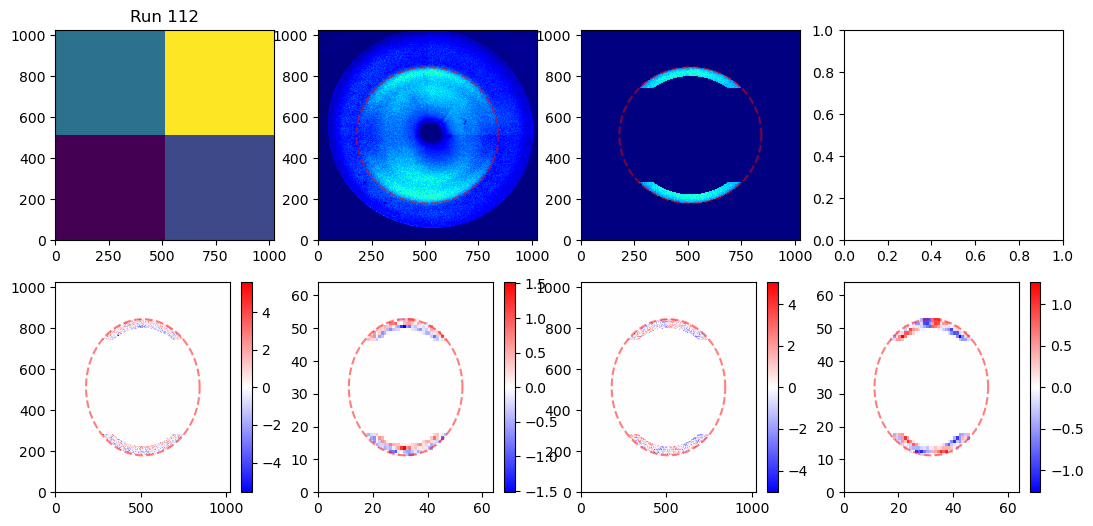

In [96]:
quads = make_quads(res.x)
#quads = make_quads([0.97,0.967,0.99,0.999])
#quads = make_quads([1,1,1,1])
# im1 = Mp
fig,axs = plt.subplots(nrows = 2, ncols =4, figsize = (13,6))
axs = axs.flatten()
axs[0].pcolormesh(quads)
implot = im1*quads
axs[1].pcolormesh(implot, cmap = 'jet', vmin = 30,vmax = 70) #vmax = 52)
axs[1].plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)

axs[2].pcolormesh(implot*maskhole, cmap = 'jet', vmin = 30,vmax = 70) #vmax = 52)
axs[2].plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)


p = axs[4].pcolormesh(implot*maskhole-np.flipud(implot)*maskhole, cmap = 'bwr') #vmax = 52)
axs[4].plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.colorbar(p,ax=axs[4])

p=axs[5].pcolormesh(rebin(rebin(implot*maskhole-np.flipud(implot)*maskhole,4),4), cmap = 'bwr') #vmax = 52)
axs[5].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
plt.colorbar(p,ax=axs[5])

p=axs[6].pcolormesh(implot*maskhole-np.fliplr(implot)*maskhole, cmap = 'bwr') #vmax = 52)
axs[6].plot((512+332*np.cos(phi_rad)), (512+332*np.sin(phi_rad)), 'r--', alpha = 0.5)
plt.colorbar(p,ax=axs[6])

p=axs[7].pcolormesh(rebin(rebin(implot*maskhole-np.fliplr(implot)*maskhole,4),4), cmap = 'bwr') #vmax = 52)
axs[7].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
plt.colorbar(p,ax=axs[7])
axs[0].set_title('Run %1.0f' %runnum);

## All quads for all detsum bins


In [110]:
detsum = np.array(detsum)
bg_ims = np.array(bg_ims)
a = np.histogram(detsum, bins = bins)
for b in range(len(bins)-1):
    X0 = [.99, 0.98, 0.95, 0.96] #, x0_1, y0_1]
    if a[0][b]>0:
        imm = np.mean(bg_ims[(bins[b]<detsum) & (detsum<bins[b+1])],axis = 0)
        im1 = cv2.warpPerspective(imm,MM,(1024,1024))
        im1[im1<0] = 0

        res = minimize(quads_error, X0, args = (im1, MM),
                       bounds = [(0.92,1), (0.92,1), (0.92,1),(0.92,1),],
                       method = 'Powell') #, options = {'maxiter': 5, 'maxfev': 4})
        quads = res.x

    else:
        quads = [0,0,0,0]

    bgdat[b]['quads'] = quads

bgdat[-1]['quads'] = [0,0,0,0] 


In [111]:
print(bgdat['quads']) ##need to use make_quads function on quads

[[0.95369133 0.95542356 0.9569135  0.96595638]
 [0.92       0.92674113 0.92578158 0.94308992]
 [0.92       0.92882372 0.93490848 0.95052448]
 [0.92       0.93152351 0.93564367 0.96122392]
 [0.92000077 0.92501523 0.93546491 0.96315694]
 [0.92000016 0.92535749 0.9379824  0.96019977]
 [0.92000077 0.92175548 0.92771527 0.95549301]
 [0.92005545 0.92000076 0.92000001 0.94921123]
 [0.92       0.92005865 0.93116273 0.95261576]
 [0.         0.         0.         0.        ]
 [0.92334387 0.92005865 0.92692456 0.93823224]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


## Fit dipole to get bg

In [94]:
#could use matrix multiplication for fit if just lstSq but should play around with cost fn.
from scipy.optimize import minimize

def lstSq(c, B, d):
    mm=np.matmul(B, c[:-1])
#     mm=100.*(mm/float(mm.sum()))
#     d=100.*(d/float(d.sum()))
    d = d - c[-1]
    res = np.power((mm - d), 2)
    cost = res.sum() + np.var(res)
    #+ np.var(np.power((mm - d), 2))*10
    #grad=(2*(mm-d)[:,None]*B).sum(0)
    return cost
lstSqLmb=lambda c,B,d: lstSq(c,B,d) #so it's a callable for optimize


/tmp/ipykernel_22166/2759173304.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(10)): #range(len(bg_ims))):#range(imsfilt32.shape[2])):


  0%|          | 0/10 [00:00<?, ?it/s]

47.284635849038565


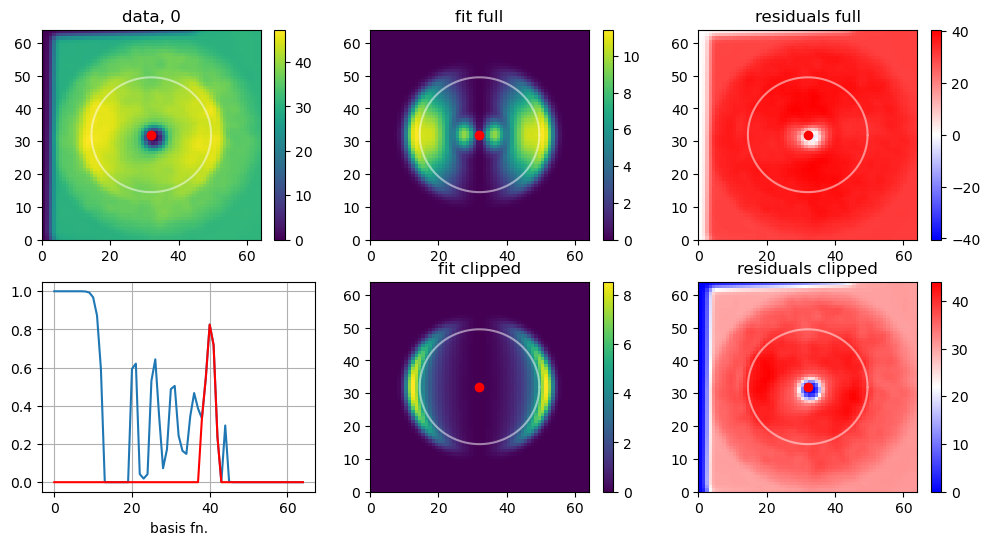

33.02173075314798
62.255913948580464


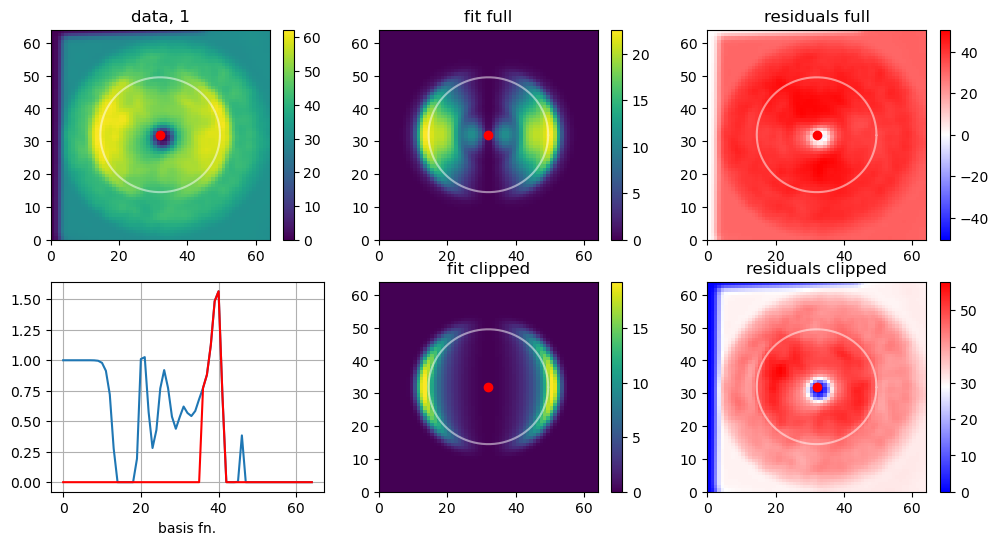

69.50031022072874
34.31173841802861


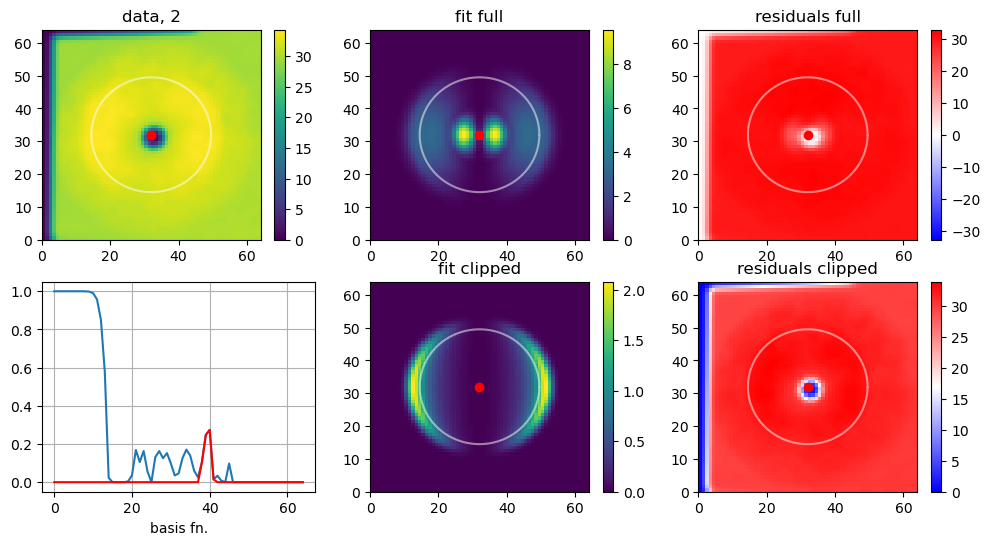

40.02509713493776


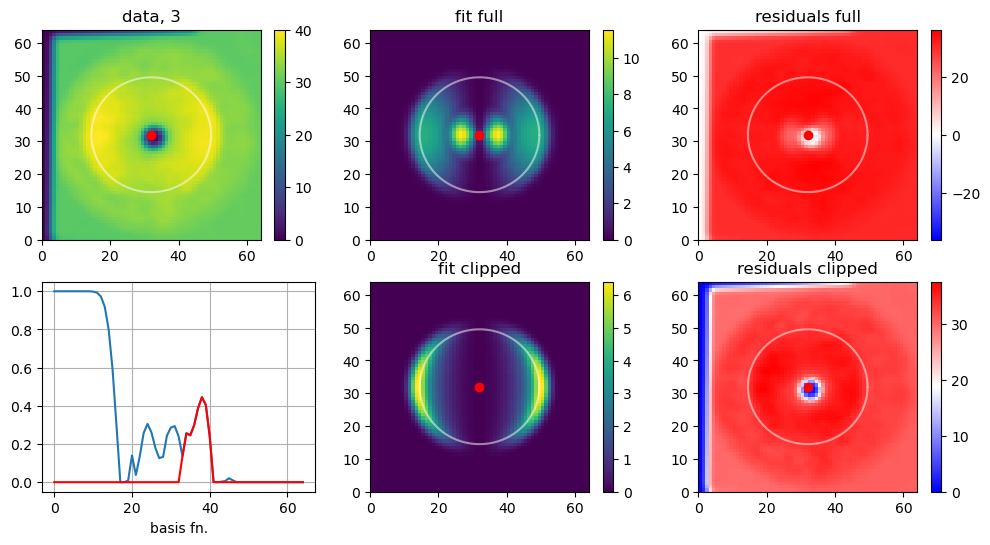

98.80192591532081
55.926937549010205


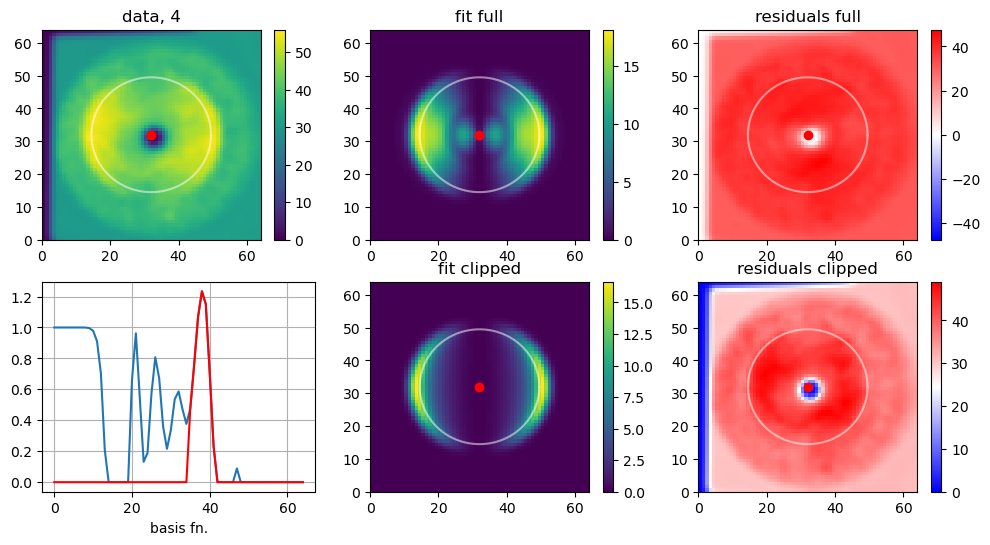

32.07069011142408
33.2514893327305


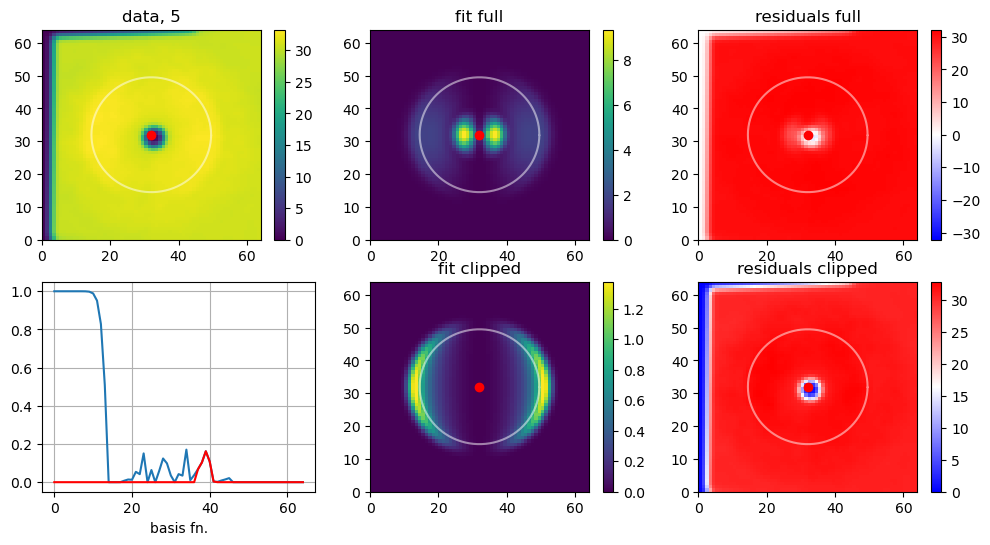

(6,)


In [144]:
nQ=65 #65 #65
xx,yy,r = 512,512,280
phi_rad = np.arange(360)*np.pi/180
B_32=get_basis(np.linspace(1, 16, nQ), nx=64)[0]

im_is=[]
detsum_im_is = []

cfits=[]
cfits_clip=[]

imfits=[]
imfits_clip=[]

residuals_=[] #underscore is for plural for list
residuals_clip_=[] #underscore is for plural for list

residuals_clip_adj=[]

skipped=[] #could except if fit fails or if no zeros to go down to for clipping


pixmask=np.ones((64,64), dtype=bool)
X,Y=np.meshgrid(np.arange(64),np.arange(64))
rs=np.sqrt((X-32)**2+(Y-32)**2)
pixmask[(rs<10)|(rs>29)] = False

pixmask_f=pixmask.flatten()
ii = 0

###change the range depending on how many images you want to include
for i in tqdm_notebook(range(10)): #range(len(bg_ims))):#range(imsfilt32.shape[2])):

    try: #could except if fit fails or if clipping finds a spike or takes whole thing
        gasoff = 0 #gasoff0 #/np.mean(gasoff0)*np.mean(bg_ims[i])
        quads = make_quads(bgdat['quads'][np.argmax(bins-detsum[i]>0)-1])
        im2fit=np.rot90(cv2.warpPerspective(np.copy(bg_ims[i])-gasoff,MM,(1024,1024))*quads) # *g #toggleforgm *g for gain map or not. Siqi multiplies by
        #siqi
        #im2fit=np.rot90(cv2.warpPerspective(np.rot90(np.copy(bg_ims[i]),-1),MM,(1024,1024))*quads)
        #print('other rot for siqi')
        
        im2fit[im2fit<0]=0
        im2fit = mf(im2fit, 25)
        im2fit = gf(im2fit, 15)
        im2fit = rebin(rebin(im2fit,4),4)
        print(np.max(im2fit))
        
        '''
        this is to try to avoid saturation
        optional
        '''
        #if((np.max(im2fit) < 33) | (np.max(im2fit)>42)) : continue
        #if((np.max(im2fit) < 50) | (np.max(im2fit)>90)) : continue
        #print('not clipping saturation')
        
        #this gain map after bg subtraction, like we do here
        d_data=im2fit.flatten() #*quad_correct/*quad_correct_sumints #toggle [calculated below] for quad correct
        #d_data=d_data/np.nanmax(d_data)
        im2fit=np.reshape(d_data, (64,64))


        res=scipy.optimize.minimize(lstSqLmb, np.ones(nQ+1), (B_32[pixmask_f],d_data[pixmask_f]), jac=None,\
                                   bounds=[(0, None) for x in range(nQ+1)])
        assert res.success

        c_fit=res.x
        c_fit = c_fit[:-1]
        #c_fit_clip=centreg(c_fit, maxbtw=(20*(nQ-1)/64.,40*(nQ-1)/64.), frac=0.05)
        c_fit_clip=centreg(c_fit, maxbtw=(37,42), frac=0.5) #frac=0.05) #(35,50)
        #c_fit_clip=centreg(c_fit, maxbtw=(28,38), frac=0.7) #frac=0.05) #(35,50) #siqi

        #assert c_fit_clip[1]>5*(nQ-1)/64. and c_fit_clip[1]<20*(nQ-1)/64. #didn't just clip a spike, or take the whole thing
        c_fit_clip=c_fit_clip[0]

        fittedim=np.reshape(np.matmul(B_32, c_fit), (64,64))
        fittedim_clip=np.reshape(np.matmul(B_32, c_fit_clip), (64,64))

        residual=im2fit-fittedim
        residual_clip=im2fit-fittedim_clip

        #now add to the residual to raise the clipped fit to the homogenous background level
        maskresdiff=np.where((residual_clip<0)*(fittedim_clip>(1e-2*np.nanmax(fittedim_clip)))) #choose
        #as a reference all places where dipole has good intensity and the residual is less than zero
        bgexpect=np.average(im2fit[27:,:5]) #small region below hole between dipole gives what
        #we expect the background to be if it is homogenous around where the dipole is
        resdiff=bgexpect-residual_clip[maskresdiff]
        resquot=resdiff/fittedim_clip[maskresdiff]
        resquotave=np.average(resquot)
        residual_clip_adj=im2fit-(1-resquotave)*fittedim_clip
        #that's done

        im_is.append(i)
        detsum_im_is.append(detsum[i])
        cfits.append(c_fit)
        cfits_clip.append(c_fit_clip)

        imfits.append(fittedim)
        imfits_clip.append(fittedim_clip)

        residuals_.append(residual)
        residuals_clip_.append(residual_clip)

        residuals_clip_adj.append(residual_clip_adj)

        
        if i<100:
            #now plot
            im2fit2plot=np.copy(im2fit)
            #im2fit2plot[~pixmask]=0

            plt.figure(figsize=(12,6))

            plt.subplot(2,3,1)
            plt.pcolormesh(im2fit2plot, vmin = 0)
            plt.colorbar()
            plt.xlim(0,64)
            plt.ylim(0,64)
            plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
            plt.plot(xx/16, yy/16, 'ro')
            plt.title('data, %1.0f' %ii)
            ii+=1

            fittedim2plot=np.copy(fittedim)
            #fittedim2plot[~pixmask]=0
            plt.subplot(2,3,2)
            plt.pcolormesh(fittedim2plot)
            plt.colorbar()
            plt.xlim(0,64)
            plt.ylim(0,64)
            plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
            plt.plot(xx/16, yy/16, 'ro')
            plt.title('fit full')

            residual2plot=np.copy(residual)
            #residual2plot[~pixmask]=0
            plt.subplot(2,3,3)
            plt.pcolormesh(residual2plot, cmap='bwr', vmax=np.nanmax(residual), vmin=-np.nanmax(residual))
            #may want to normalize colormap to something else in future?
            plt.colorbar()
            plt.xlim(0,64)
            plt.ylim(0,64)
            plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
            plt.plot(xx/16, yy/16, 'ro')
            plt.title('residuals full')

            plt.subplot(2,3,4)
            #plt.plot(np.matmul(fkr, c_fit))
            plt.plot(c_fit)
            plt.plot(c_fit_clip, 'r')
            # plt.ylabel('coefficient')
            plt.xlabel('basis fn.')
            plt.grid()

            fittedim_clip2plot=np.copy(fittedim_clip)
            # fittedim2plot[~pixmask]=0
            plt.subplot(2,3,5)
            plt.pcolormesh(fittedim_clip2plot)
            plt.colorbar()
            plt.xlim(0,64)
            plt.ylim(0,64)
            plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
            plt.plot(xx/16, yy/16, 'ro')
            plt.title('fit clipped')


            residual_clip2plot=np.copy(residual_clip)
            # residual2plot[~pixmask]=0
            plt.subplot(2,3,6)
            plt.pcolormesh(residual_clip2plot, cmap='bwr', vmax=np.nanmax(residual_clip2plot), \
                           vmin=0)#-np.nanmax(residual_clip2plot))
            #may want to normalize colormap to something else in future?
            plt.colorbar()
            plt.xlim(0,64)
            plt.ylim(0,64)
            plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
            plt.plot(xx/16, yy/16, 'ro')
            plt.title('residuals clipped')

            plt.show()

    except:
        continue

im_is=np.array(im_is)

cfits=np.array(cfits)
cfits_clip=np.array(cfits_clip)

imfits=np.array(imfits)
imfits_clip=np.array(imfits_clip)

residuals_=np.array(residuals_)
residuals_clip_=np.array(residuals_clip_)

print(im_is.shape)

In [146]:
toplot = np.zeros((1024,1024))
bg_ims_str = []
for i in range(len(bg_ims)):
    check = bg_ims[i]
    quads = make_quads(bgdat['quads'][np.argmax(bins-detsum[i]>0)-1])
    #check[check < 40] = 0
    #check[check < 20] = 0
    #toplot += check
    gasoff = 0 #gasoff0 #/np.mean(gasoff0*maskscale2)*np.mean(check*maskscale2)
    checkk =  (cv2.warpPerspective(check-gasoff,MM,(1024,1024))*quads) 
    #checkk =  (cv2.warpPerspective(check,MM,(1024,1024))*quads) 
    checkk[checkk<0] = 0
    toplot = toplot + checkk
    bg_ims_str.append(checkk)
toplot = toplot/len(bg_ims)

bg_ims_str = np.array(bg_ims_str)

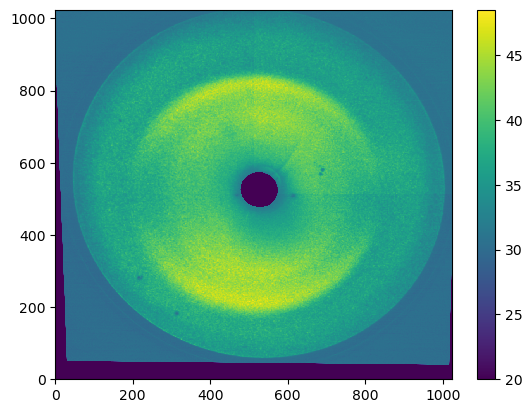

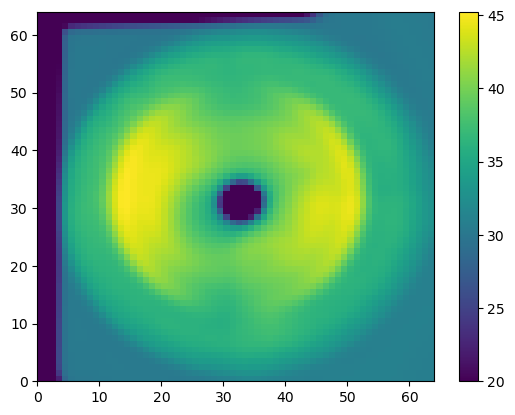

In [149]:
plt.pcolormesh(np.mean(bg_ims_str,axis = 0), vmin = 20)
plt.colorbar()
plt.show()
a = np.rot90(rebin(rebin(gf(mf(np.mean(bg_ims_str,axis = 0),25),15),4),4))
plt.pcolormesh(a, vmin = 20)
plt.colorbar()

## make bgs all at once for all bins

In [ ]:
a = np.histogram(detsum, bins = bins)
for b in range(len(bins)-1):
    X0 = [.99, 0.98, 0.95, 0.96] #, x0_1, y0_1]
    if a[0][b]>0:
        imm = np.mean(bg_ims[(bins[b]<detsum) & (detsum<bins[b+1])],axis = 0)
        im1 = cv2.warpPerspective(imm,MM,(1024,1024))
        im1[im1<0] = 0

        res = minimize(quads_error, X0, args = (im1, MM),
                       bounds = [(0.92,1), (0.92,1), (0.92,1),(0.92,1),],
                       method = 'Powell') #, options = {'maxiter': 5, 'maxfev': 4})
        quads = res.x

    else:
        quads = [0,0,0,0]

    bgdat[b]['quads'] = quads

bgdat[-1]['quads'] = [0,0,0,0] 
fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10,3))

## not binning

In [45]:
ii = np.arange(len(im_is))
b=np.rot90(rebin(rebin(gf(mf(np.mean(bg_ims_str[im_is[ii]],axis = 0),25),15),4),4))

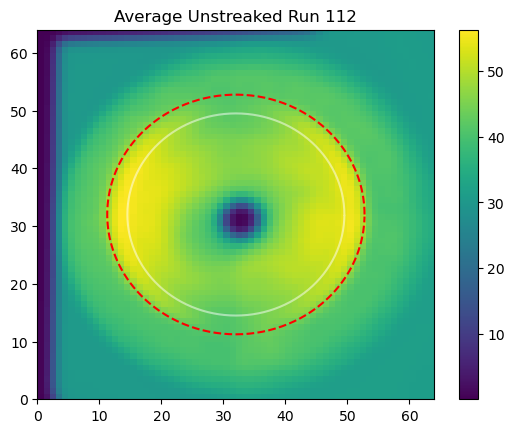

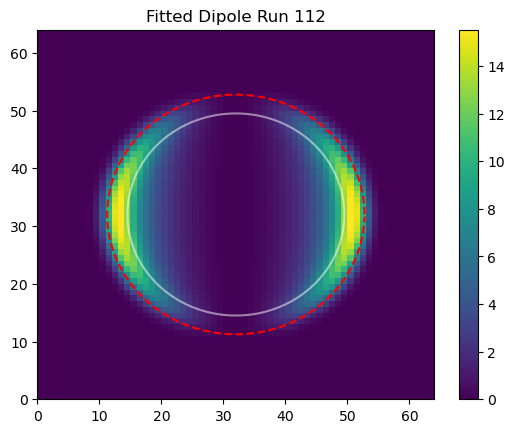

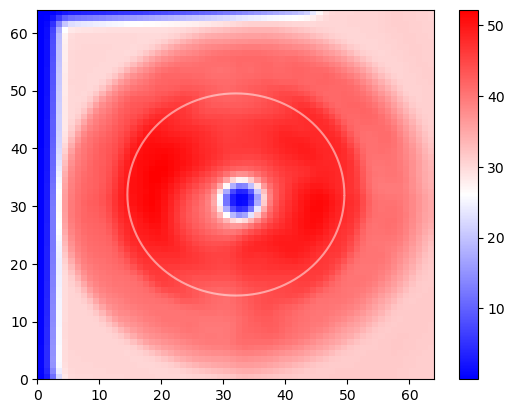

In [46]:
#b= np.rot90(rebin(rebin(gf(mf(bg_ims[im_is[1]],20),20),4),4))
plt.pcolormesh(b)
plt.colorbar()
plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+332*np.cos(phi_rad))/16, (yy+332*np.sin(phi_rad))/16, 'r--')
plt.title('Average Unstreaked Run %1.0f' %runnum)
plt.show()
plt.pcolormesh(np.mean(imfits_clip[ii],axis = 0))
plt.colorbar()
plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+332*np.cos(phi_rad))/16, (yy+332*np.sin(phi_rad))/16, 'r--')
plt.title('Fitted Dipole Run %1.0f' %runnum)
plt.show()
plt.pcolormesh(b-0.5*np.mean(imfits_clip[ii],axis = 0),  cmap = 'bwr')
plt.colorbar()
plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.show()


## scale dipole to unstreaked images so you are not artificially introducing dipole structure

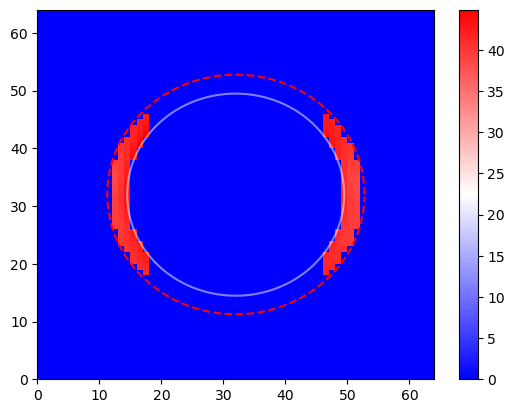

In [47]:
pixmask2=np.ones((64,64), dtype=bool)
#pixmask[24:40, 22:42]=False
X,Y=np.meshgrid(np.arange(64),np.arange(64))
rs=np.sqrt((X-31.5)**2+(Y-31.5)**2)
#pixmask2[(rs>21.4)|(rs<18.2)] = False
pixmask2[(rs>20.4)|(rs<17.5)] = False
pixmask2[(X>17)&(X<46)] = False
#pixmask2[(X>20)&(X<43.4)] = False
plt.pcolormesh(pixmask2*(b-np.mean(imfits_clip[ii],axis = 0)),  cmap = 'bwr')
plt.plot((511.5+r*np.cos(phi_rad))/16, (511.5+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+332*np.cos(phi_rad))/16, (yy+332*np.sin(phi_rad))/16, 'r--')

plt.colorbar()
plt.show()

In [48]:
var = []
sums = []
for i in np.linspace(0.1,2,200):
    s = (b-i*np.mean(imfits_clip[ii],axis = 0))
    #s = (a-i*np.mean(imfits_clip[ii],axis = 0))
    s = s[pixmask2]
    var.append(np.var(s))
    sums.append(np.sum(s**2))

0.6728643216080401

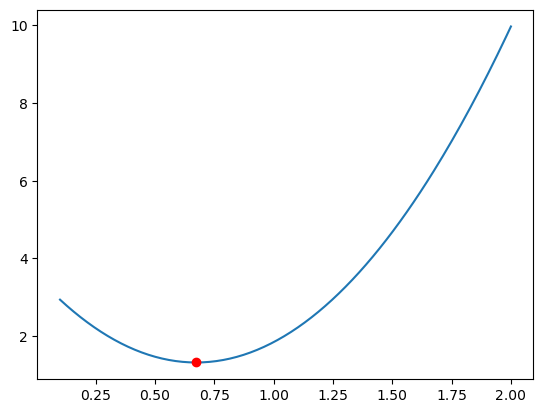

In [49]:
plt.plot(np.linspace(0.1,2,200), var)
plt.plot(np.linspace(0.1,2,200)[np.argmin(var)], var[np.argmin(var)], 'ro')
mpt = np.linspace(0.1,2,200)[np.argmin(var)]
mpt

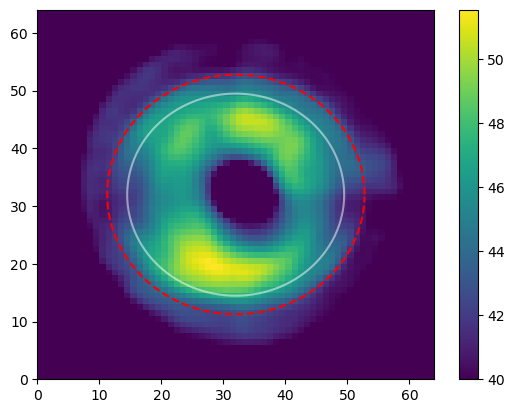

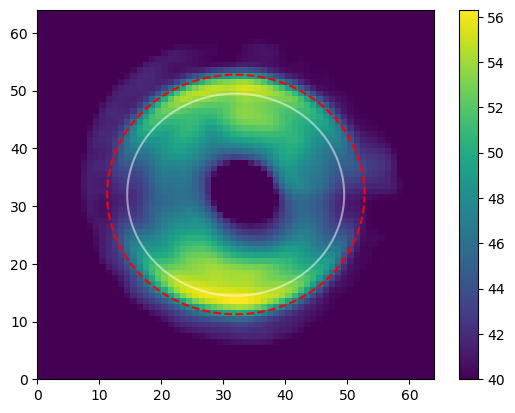

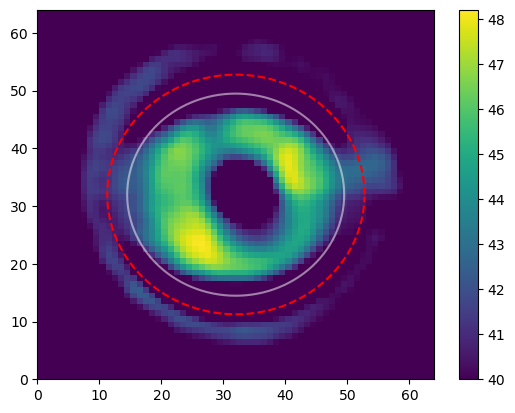

In [52]:
plt.pcolormesh(np.rot90(b-mpt*np.mean(imfits_clip[ii],axis = 0),  -1), vmin = 40)
#plt.pcolormesh(np.rot90(a-mpt*np.mean(imfits_clip[ii],axis = 0),  -1), vmin = 30)
plt.colorbar()
plt.plot((511.5+r*np.cos(phi_rad))/16, (511.5+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+332*np.cos(phi_rad))/16, (yy+332*np.sin(phi_rad))/16, 'r--')
plt.show()

plt.pcolormesh(np.rot90(b,  -1), vmin = 40)
#plt.pcolormesh(np.rot90(a,  -1), vmin = 30)
plt.colorbar()
plt.plot((511.5+r*np.cos(phi_rad))/16, (511.5+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+332*np.cos(phi_rad))/16, (yy+332*np.sin(phi_rad))/16, 'r--')
plt.show()

plt.pcolormesh(np.rot90(b-2*np.mean(imfits_clip[ii],axis = 0),  -1), vmin = 40)
#plt.pcolormesh(np.rot90(a-2*np.mean(imfits_clip[ii],axis = 0),  -1), vmin = 30)
plt.colorbar()
plt.plot((511.5+r*np.cos(phi_rad))/16, (511.5+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+332*np.cos(phi_rad))/16, (yy+332*np.sin(phi_rad))/16, 'r--')
plt.show()

In [53]:
fname = 'bg_run_'+ str(runnum)+'_Jul27_2.npy'
fname

'bg_run_112_Jul27_2.npy'

In [54]:
pwd

'/cds/home/p/paris/reconVMI_clean/recon X510 Jan'

In [55]:
np.save(fname, np.rot90(b-mpt*np.mean(imfits_clip[ii],axis = 0),  -1))

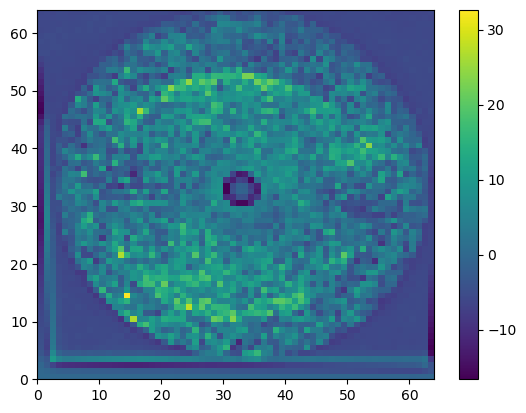

In [87]:
plt.pcolormesh(rebin(rebin(bg_ims_str[im_is[5]],4),4)- 1.2*np.rot90(b-mpt*np.mean(imfits_clip[ii],axis = 0),  -1))
plt.colorbar()

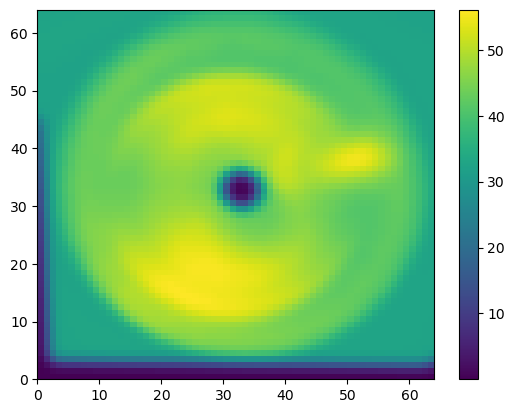

In [90]:
plt.pcolormesh(np.rot90(a,  -1))
plt.colorbar()

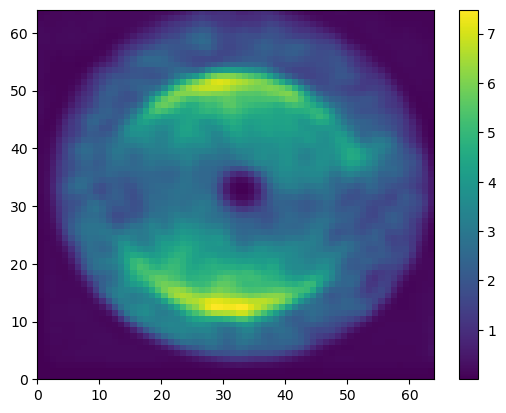

In [89]:
plt.pcolormesh(np.rot90(a,  -1)- np.rot90(b-mpt*np.mean(imfits_clip[ii],axis = 0),  -1))
plt.colorbar()

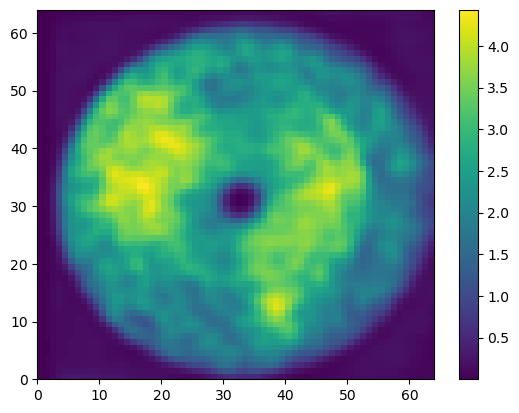

In [44]:
plt.pcolormesh(a-b)
plt.colorbar()

## Siqi rotation

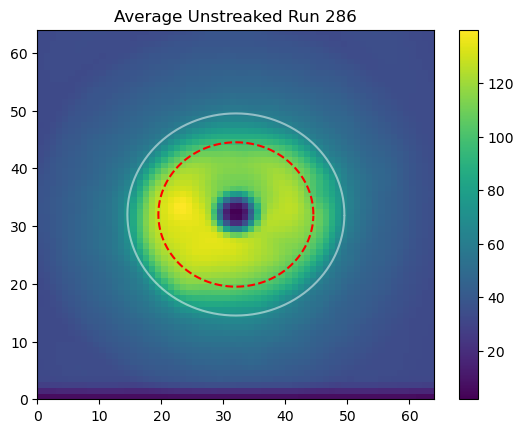

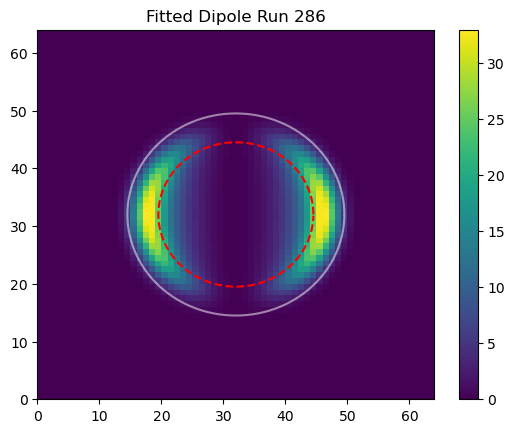

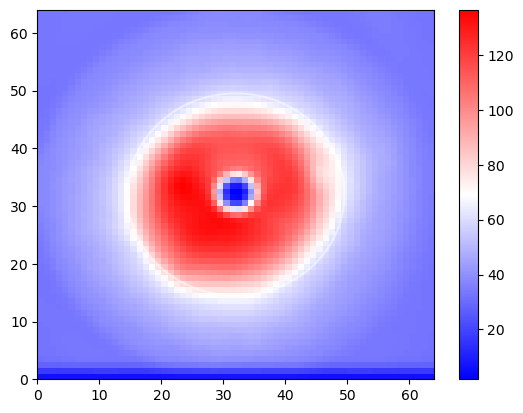

In [49]:
#siqi rotation
b = np.rot90(rebin(rebin(gf(mf(cv2.warpPerspective(np.rot90(np.mean(bg_ims[:len(cfits)],axis = 0),-1),MM,(1024,1024))*quads,25),15),4),4))

plt.pcolormesh(b)
plt.colorbar()
plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')
plt.title('Average Unstreaked Run %1.0f' %runnum)
plt.show()
plt.pcolormesh(np.mean(imfits_clip[:],axis = 0))
plt.colorbar()
plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')
plt.title('Fitted Dipole Run %1.0f' %runnum)
plt.show()
plt.pcolormesh(b-0.5*np.mean(imfits_clip[:],axis = 0),  cmap = 'bwr')
plt.colorbar()
plt.plot((xx+r*np.cos(phi_rad))/16, (yy+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.show()


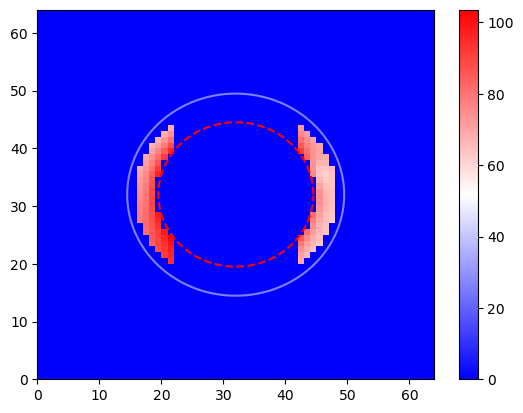

In [68]:
pixmask2=np.ones((64,64), dtype=bool)
#pixmask[24:40, 22:42]=False
X,Y=np.meshgrid(np.arange(64),np.arange(64))
rs=np.sqrt((X-31.5)**2+(Y-31.5)**2)
#pixmask2[(rs>21.4)|(rs<18.2)] = False
pixmask2[(rs>16.2)|(rs<12.8)] = False
pixmask2[(X>17+4)&(X<46-4)] = False
#pixmask2[(X>20)&(X<43.4)] = False
plt.pcolormesh(pixmask2*(b-np.mean(imfits_clip[:],axis = 0)),  cmap = 'bwr')
plt.plot((511.5+r*np.cos(phi_rad))/16, (511.5+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')

plt.colorbar()
plt.show()

1.092964824120603

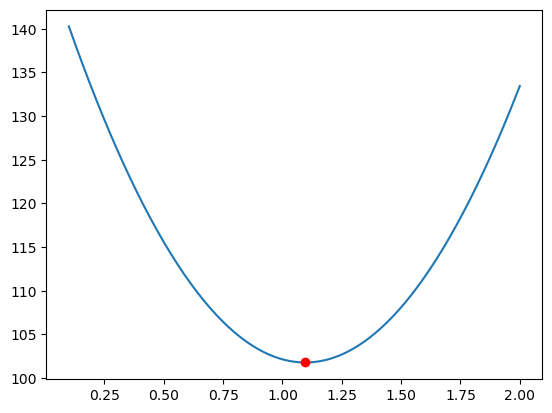

In [69]:
var = []
sums = []
for i in np.linspace(0.1,2,200):
    s = (b-i*np.mean(imfits_clip[:],axis = 0))
    s = s[pixmask2]
    var.append(np.var(s))
    sums.append(np.sum(s**2))
    
plt.plot(np.linspace(0.1,2,200), var)
plt.plot(np.linspace(0.1,2,200)[np.argmin(var)], var[np.argmin(var)], 'ro')
mpt = np.linspace(0.1,2,200)[np.argmin(var)]
mpt

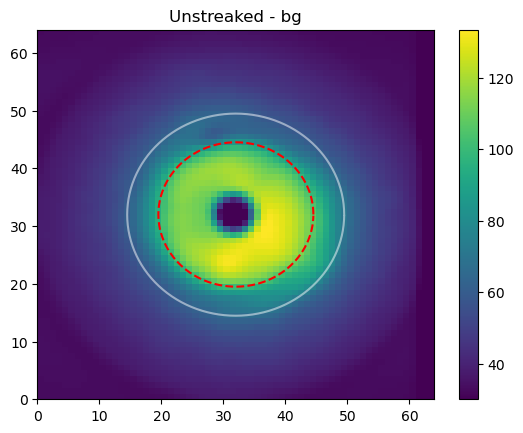

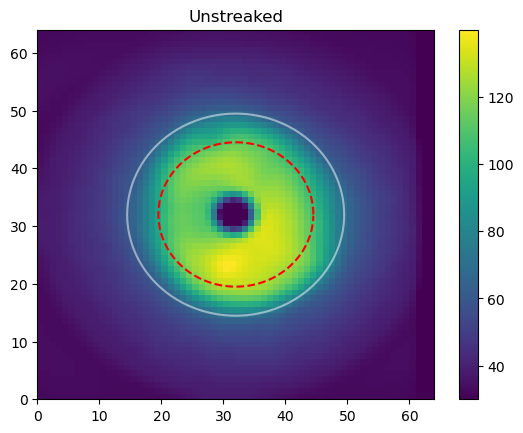

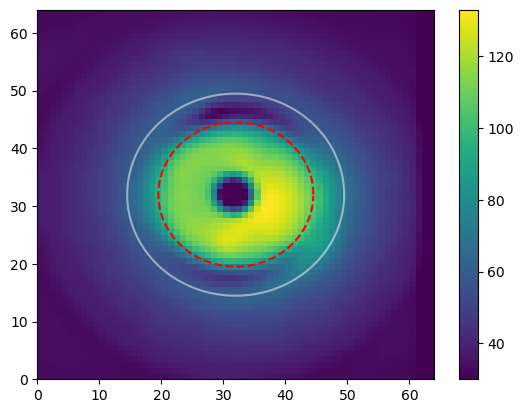

In [74]:
plt.pcolormesh(np.rot90(b-mpt*np.mean(imfits_clip[:],axis = 0),  -1), vmin = 30)
plt.colorbar()
plt.plot((511.5+r*np.cos(phi_rad))/16, (511.5+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')
plt.title('Unstreaked - bg')
plt.show()

plt.pcolormesh(np.rot90(b,  -1), vmin = 30)
plt.colorbar()
plt.plot((511.5+r*np.cos(phi_rad))/16, (511.5+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')
plt.title('Unstreaked')
plt.show()

plt.pcolormesh(np.rot90(b-2*np.mean(imfits_clip[:],axis = 0),  -1), vmin = 30)
plt.colorbar()
plt.plot((511.5+r*np.cos(phi_rad))/16, (511.5+r*np.sin(phi_rad))/16, c='white', alpha = 0.5)
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')
plt.show()

In [73]:
np.save('/cds/home/p/paris/bg_286_siqi.npy', np.rot90(b-mpt*np.mean(imfits_clip[:],axis = 0),  -1))

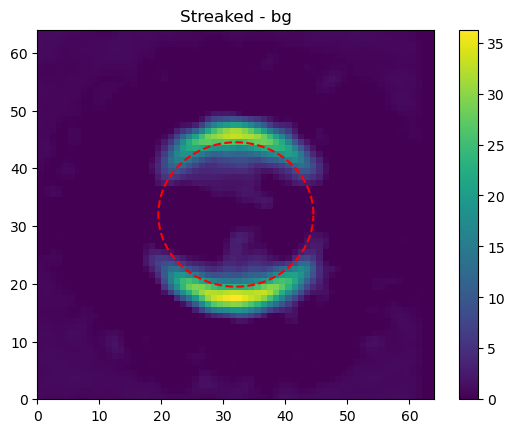

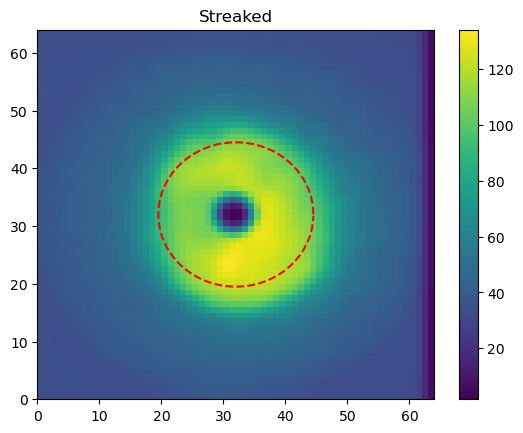

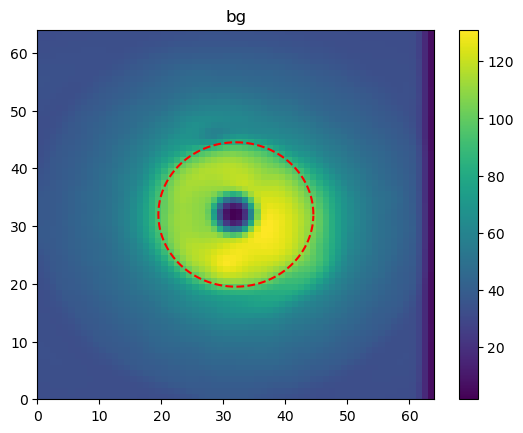

In [255]:
maskscale = np.zeros((1024,1024))
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskscale[(rs>60) & (rs<150)]=1
resid = np.load('/cds/home/p/paris/bg_286_siqi.npy')
ims2 = rebin(rebin(gf(mf(cv2.warpPerspective(np.rot90(streak_ims[114],-1),MM,(1024,1024))*quads,25),15),4),4) #33,47,71,72,87,91,94,114,116,117
resid_scale = resid/np.mean(resid*rebin(rebin(maskscale,4),4))*np.mean(ims2*rebin(rebin(maskscale,4),4))
s =ims2
mm = s-resid_scale
mm[mm<0] = 0
plt.pcolormesh(mm)
plt.colorbar()
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')
plt.title('Streaked - bg')
plt.show()

plt.pcolormesh(s)
plt.colorbar()
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')
plt.title('Streaked')
plt.show()

plt.pcolormesh(resid_scale)#*rebin(rebin(maskscale,4),4))
plt.colorbar()
plt.plot((xx+200*np.cos(phi_rad))/16, (yy+200*np.sin(phi_rad))/16, 'r--')
plt.title('bg')
plt.show()